In [1]:
import pandas as pd
import numpy as np

***Carrega as bases e adiciona a classificação na base de teste***

In [2]:
train_base = pd.read_csv('train/train.csv')
test_base = pd.read_csv('test/test.csv')
test_base_y = pd.read_csv('test/test_labels.csv')

In [3]:
train_base['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [4]:
test_base_y

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [5]:
test_base = pd.merge(test_base, test_base_y, on='id')

In [6]:
test_base.drop('id', axis=1, inplace=True)

In [7]:
train_base.drop('id', axis=1, inplace=True)

***Realiza o pré-processamento das bases***

In [8]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


In [9]:
#separa uma amostra das bases apenas
train_base = train_base.sample(frac=0.1, random_state=42)
test_base = test_base.sample(frac=0.1, random_state=42)

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
stemmer = PorterStemmer()

**Pré-processamento de um texto**

In [12]:
def preprocess_text(text):
    #Filtro para ter apenas letras e espaços
    caracteres = string.ascii_letters + " "
    text = re.sub('[^' + caracteres + ']', '', text)
    
    #Tokenização
    tokens = word_tokenize(text.lower())
    
    #Remoção de stopwords e stemming
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if not token in stop_words]
    
    #stemming
    tokens = [stemmer.stem(token) for token in tokens]

    #reune tokens em uma string novamente
    text = " ".join(tokens)
    
    return text

In [13]:
len(test_base.index)

15316

In [14]:
train_base['comment_text'] = train_base['comment_text'].apply(preprocess_text)
test_base['comment_text'] = test_base['comment_text'].apply(preprocess_text)

In [15]:
train_base

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
119105,geez forget weve alreadi discuss marx anarchis...,0,0,0,0,0,0
131631,carioca rfa thank support request adminshipth ...,0,0,0,0,0,0
125326,birthday worri enjoy ur daytalk,0,0,0,0,0,0
111256,pseudosci categori im assum articl pseudosci c...,0,0,0,0,0,0
83590,phrase exist would provid search engin even me...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
68192,recent page move see also unresolv discuss reg...,0,0,0,0,0,0
50285,pleas stop disrupt edit vandal continu block e...,0,0,0,0,0,0
153486,lake outlet sea clearli titl river also regard...,0,0,0,0,0,0
94271,dont believ need use monobook thingi done ive ...,0,0,0,0,0,0


***Transforma as bases separando por pelo TI\*IDF de cada palavra***

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer()

x_train = vectorizer.fit_transform(train_base['comment_text'])
y_train = train_base.drop('comment_text', axis=1)

x_test = vectorizer.transform(test_base['comment_text'])
y_test = test_base.drop('comment_text', axis=1)


In [18]:
x_train.shape

(15957, 43366)

In [19]:
x_test.shape

(15316, 43366)

***Executa o problema multirótulo em uma RandomForest***

In [20]:
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

In [21]:
mlp = MLPClassifier()

In [22]:
multiClassifier = BinaryRelevance(classifier=mlp)

In [23]:
multiClassifier.fit(x_train, y_train)

BinaryRelevance(classifier=MLPClassifier(), require_dense=[True, True])

**Predizendo os valores para teste do modelo**

In [24]:
y_test.reset_index(drop=True, inplace=True)

In [25]:
x_test = pd.DataFrame(x_test.toarray())

In [26]:
for col in y_test.columns:
    x_test.drop(y_test.loc[y_test[col] == -1].index, inplace=True)
    y_test.drop(y_test.loc[y_test[col] == -1].index, inplace=True)


In [27]:
y_pred = multiClassifier.predict(x_test)

In [28]:
y_pred = pd.DataFrame(y_pred.toarray(), columns=y_test.columns)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.69      0.61       612
           1       0.26      0.24      0.25        41
           2       0.63      0.60      0.61       387
           3       0.57      0.17      0.27        23
           4       0.52      0.52      0.52       351
           5       0.51      0.35      0.41        72

   micro avg       0.55      0.59      0.57      1486
   macro avg       0.51      0.43      0.45      1486
weighted avg       0.55      0.59      0.56      1486
 samples avg       0.06      0.05      0.05      1486



c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pedro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


toxic
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      5900
           1       0.55      0.69      0.61       612

    accuracy                           0.92      6512
   macro avg       0.76      0.82      0.78      6512
weighted avg       0.93      0.92      0.92      6512



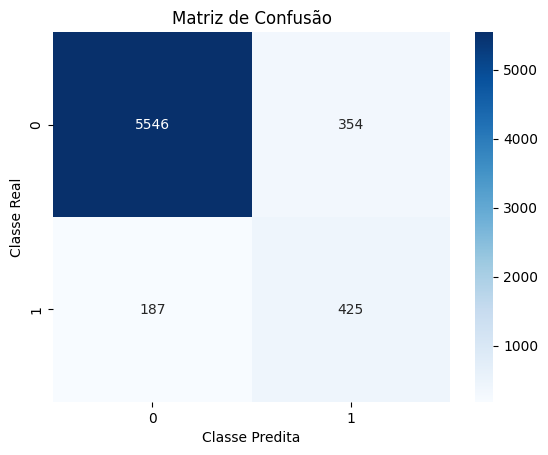


severe_toxic
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6471
           1       0.26      0.24      0.25        41

    accuracy                           0.99      6512
   macro avg       0.63      0.62      0.62      6512
weighted avg       0.99      0.99      0.99      6512



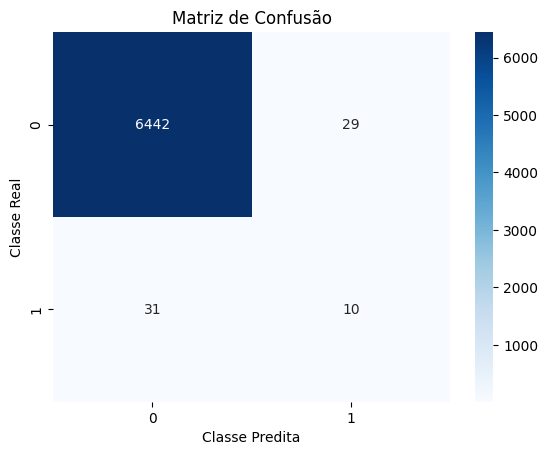


obscene
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6125
           1       0.63      0.60      0.61       387

    accuracy                           0.95      6512
   macro avg       0.80      0.79      0.79      6512
weighted avg       0.95      0.95      0.95      6512



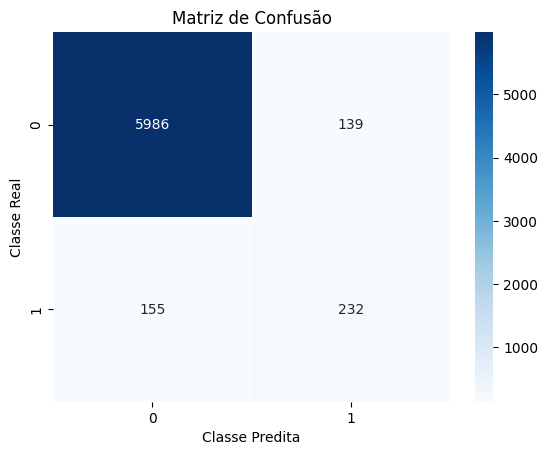


threat
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6489
           1       0.57      0.17      0.27        23

    accuracy                           1.00      6512
   macro avg       0.78      0.59      0.63      6512
weighted avg       1.00      1.00      1.00      6512



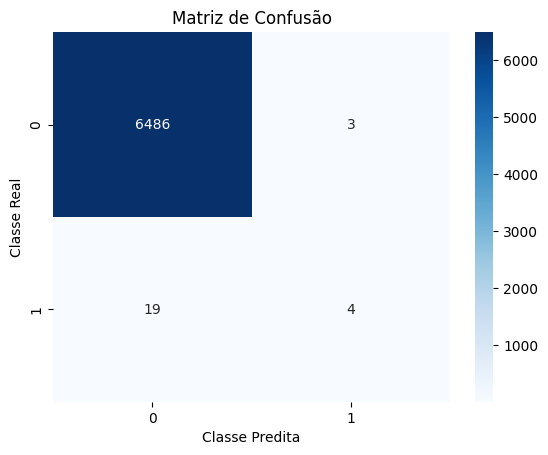


insult
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6161
           1       0.52      0.52      0.52       351

    accuracy                           0.95      6512
   macro avg       0.75      0.74      0.75      6512
weighted avg       0.95      0.95      0.95      6512



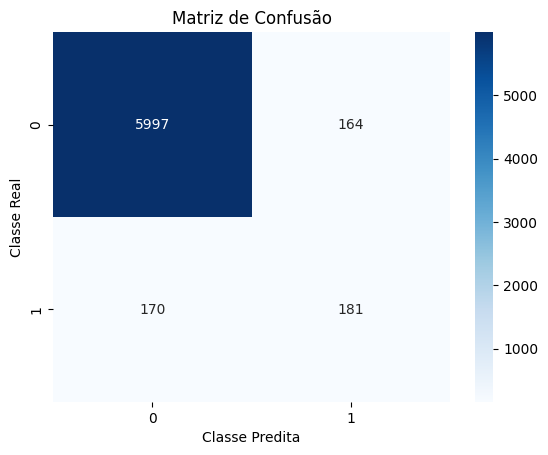


identity_hate
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6440
           1       0.51      0.35      0.41        72

    accuracy                           0.99      6512
   macro avg       0.75      0.67      0.70      6512
weighted avg       0.99      0.99      0.99      6512



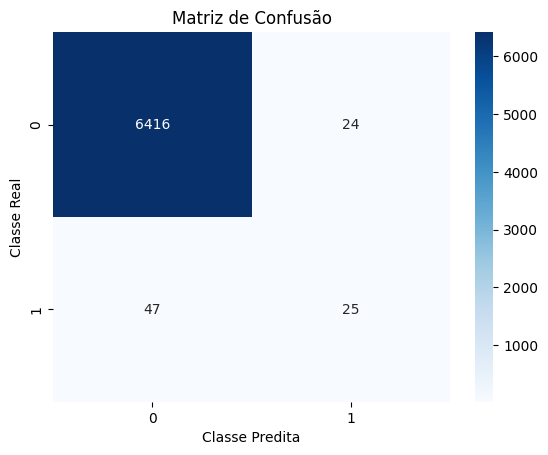

In [30]:
for col in y_test.columns:
    print(col)
    print(classification_report(y_test[col], y_pred[col]))
    cm = confusion_matrix(y_test[col], y_pred[col])
    
    classes = [0,1]
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, fmt='d', cmap='Blues')
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Real')
    plt.title('Matriz de Confusão')
    plt.show()

    print("")